Install Open Dataset to bring the dataset here

In [ ]:
from google.colab import drive
import shutil, csv

In [ ]:


drive.mount('/content/drive')
shutil.copy('/content/drive/MyDrive/3 - JE-Net Data/LT_Ankle.zip', 'LT_Ankle.zip')
shutil.copy('/content/drive/MyDrive/3 - JE-Net Data/LT_Bones.zip', 'LT_Bones.zip')
shutil.copy('/content/drive/MyDrive/3 - JE-Net Data/arial.ttf', 'arial.ttf')
drive.flush_and_unmount()

Mounted at /content/drive


In [ ]:
import zipfile

Ankle_image_zip_address = '/content/LT_Ankle.zip'
Bones_image_zip_address = '/content/LT_Bones.zip'
Ankle_images_dir = '/content/LT_Ankle/'
Bones_images_dir = '/content/LT_Bones/'



In [ ]:
with zipfile.ZipFile(Ankle_image_zip_address, 'r') as zip_ref:
    zip_ref.extractall('/content')
shutil.move('LT', Ankle_images_dir)
with zipfile.ZipFile(Bones_image_zip_address, 'r') as zip_ref:
    zip_ref.extractall('/content')
shutil.move('LT', Bones_images_dir)

'/content/LT_Bones/'

Import required libraries

In [ ]:
from matplotlib import pyplot as plt
from matplotlib import image
from PIL import Image
import numpy as np
import os, random
import torch
from torchvision import transforms

!pip install tensorflow==2.15.0
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 80.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 67.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 113.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 41.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 9.2 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.17.0
    Uninstalling wrapt-1.17.0:
      Successfully uninstalled wrapt-1.17.0
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.1
    Uninstalling ml-dtypes-0.4.1:
      Successfully uninstalled ml-dtypes-0.4.1
  Attempting uninstall: keras
    Found existing installation: keras 3.5.0
    Uninstalling keras-3.5.0:
      Successfully uninstalled keras-3.5.0
  Attempting uninstall: tensorboard
    Found existing installatio

In [ ]:
print(tf. __version__)

2.15.0


If we want to train the model from scratch, or we need to load it from the drive

In [ ]:
train_the_model = 1

Split the data into train/test randomly and put them into sensor batch format to be used by Keras

In [ ]:
input_images_dir = Ankle_images_dir
output_images_dir = Bones_images_dir
# [400, 980] Original size # This is set for the LT images.
# [384, 960] is very close to the size of original images dividing by 64
# but we had to resize it so it can be used in the network [288, 720] It was working with [272, 688]
image_resolutions = [304, 736] # This was good for 10K instances but now we have 15K
image_resolutions = [240, 592] # This is good for 15K instances
train_test_percentage = 0.1

def read_lines(filepath):
    with open(filepath, 'rU') as data:
        reader = csv.reader(data)
        for row in reader:
            yield [ float(i) for i in row ]




files = os.listdir(input_images_dir)
files.sort(key=lambda f: int(f.split('.')[0]))
if train_the_model == 1:
    test_idx = random.sample(range(0, len(files)), round(len(files)*train_test_percentage))
    with open('Test_Ids_LT.csv', 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(test_idx)
    drive.mount('/content/drive')
    shutil.copy("Test_Ids_LT.csv", "/content/drive/MyDrive/3 - JE-Net Data/Test_Ids_LT.csv")
    drive.flush_and_unmount()
else:
    drive.mount('/content/drive')
    shutil.copy("/content/drive/MyDrive/3 - JE-Net Data/Test_Ids_LT.csv", "Test_Ids_LT.csv")
    Test_Ids_filepath = 'Test_Ids_LT.csv'
    Test_Ids = list(read_lines(Test_Ids_filepath))
    Test_Ids_Temp = []
    for line in Test_Ids:
        Test_Ids_Temp.extend(map(int, line))
    test_idx = Test_Ids_Temp
    drive.flush_and_unmount()

train_input_images = []
test_input_images = []

for idx, file in enumerate(files):
    my_image = tf.io.read_file(input_images_dir + file)
    tensor = tf.io.decode_image(my_image, channels=1, dtype=tf.dtypes.float32)
    tensor_image = tf.image.resize(tensor, [image_resolutions[0], image_resolutions[1]])
    # tensor_image = tf.expand_dims(tensor_image, axis=0)
    if test_idx.count(idx) > 0:
        test_input_images.append(tensor_image)
    else:
        train_input_images.append(tensor_image)

test_input_images = tf.stack(test_input_images)
train_input_images = tf.stack(train_input_images)

files = os.listdir(output_images_dir)
files.sort(key=lambda f: int(f.split('.')[0]))
train_output_images = []
test_output_images = []

for idx, file in enumerate(files):
    my_image = tf.io.read_file(output_images_dir + file)
    tensor = tf.io.decode_image(my_image, channels=1, dtype=tf.dtypes.float32)
    tensor_image = tf.image.resize(tensor, [image_resolutions[0], image_resolutions[1]])
    # tensor_image = tf.expand_dims(tensor_image, axis=0)
    if test_idx.count(idx) > 0:
        test_output_images.append(tensor_image)
    else:
        train_output_images.append(tensor_image)

test_output_images = tf.stack(test_output_images)
train_output_images = tf.stack(train_output_images)

Mounted at /content/drive


Randomly show a Training input and its desired output, and a Test input and its desired output. The images generated each time is choosed rendomly

(-0.5, 591.5, 239.5, -0.5)

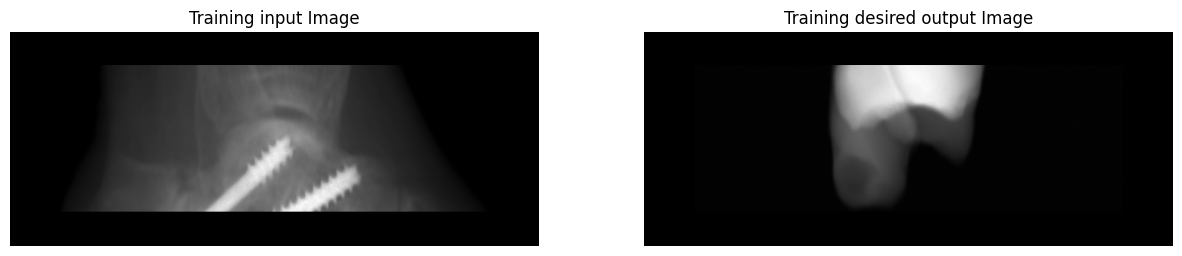

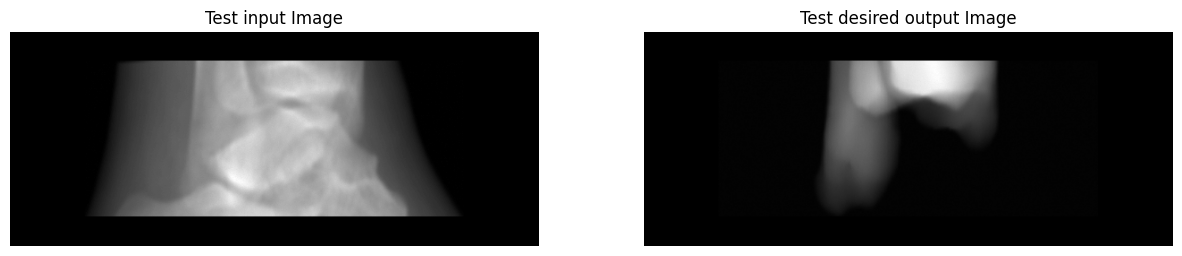

In [ ]:
%matplotlib inline
rand_idx = random.randint(0, len(train_input_images))
im1 = tf.squeeze(tf.slice(train_input_images, begin=[rand_idx,0,0,0], size=[1, image_resolutions[0], image_resolutions[1], 1]),[0,3])
im2 = tf.squeeze(tf.slice(train_output_images, begin=[rand_idx,0,0,0], size=[1, image_resolutions[0], image_resolutions[1], 1]),[0,3])

plt.rcParams['figure.figsize'] = [15, 15]
fig, ax = plt.subplots(1,2)
ax[0].imshow(im1, cmap='gray')
ax[1].imshow(im2 , cmap='gray')
ax[0].set_title('Training input Image')
ax[1].set_title('Training desired output Image')
ax[0].axis('off')
ax[1].axis('off')

rand_idx = random.randint(0, len(test_input_images))
im1 = tf.squeeze(tf.slice(test_input_images, begin=[rand_idx,0,0,0], size=[1, image_resolutions[0], image_resolutions[1], 1]),[0,3])
im2 = tf.squeeze(tf.slice(test_output_images, begin=[rand_idx,0,0,0], size=[1, image_resolutions[0], image_resolutions[1], 1]),[0,3])

fig, ax = plt.subplots(1,2)
ax[0].imshow(im1, cmap='gray')
ax[1].imshow(im2 , cmap='gray')
ax[0].set_title('Test input Image')
ax[1].set_title('Test desired output Image')
ax[0].axis('off')
ax[1].axis('off')

Config the Network and run the training process. You can also use next block of Code to load what has been trained before.

In [ ]:
from keras import backend as K
from keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler,ReduceLROnPlateau
from keras.optimizers import Adam

def create_model(image_resolutions, learning_rate, alpha, dropout_rate):
    input = layers.Input(shape=(image_resolutions[0], image_resolutions[1], 1))

    # Encoder
    x = layers.Conv2D(32, (4 , 4), strides=(1, 1), activation="relu", padding="same")(input)
    x = layers.Dropout(dropout_rate)(x)  # Dropout with rate 0.3
    x = layers.Conv2D(32, (4, 4), strides=(2, 2), activation="relu", padding="same")(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Conv2D(48, (4, 4), strides=(2, 2), activation="relu", padding="same")(x)
    x = layers.Conv2D(48, (4, 4), strides=(2, 2), activation="relu", padding="same")(x)
    x = layers.Conv2D(48, (4, 4), strides=(2, 2), activation="relu", padding="same")(x)

    # Decoder
    x = layers.Conv2DTranspose(48, (4, 4), strides=(2, 2), activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(48, (4, 4), strides=(2, 2), activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(48, (4, 4), strides=(2, 2), activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(32, (4, 4), strides=(2, 2), activation="relu", padding="same")(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Conv2DTranspose(32, (4, 4), strides=(1, 1), activation="relu", padding="same")(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Conv2D(1, (4, 4), activation="sigmoid", padding="same")(x)

    loss1 = ssim_loss
    loss2 = tf.keras.losses.MeanSquaredError()

    autoencoder = Model(input, x)
    optimizer = Adam(learning_rate=learning_rate)
    autoencoder.compile(optimizer=optimizer, loss=[loss1,loss2],loss_weights=[alpha,1-alpha])
    # autoencoder.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate), loss=[loss1,loss2],loss_weights=[alpha,1-alpha])  # SGD
    autoencoder.summary()
    return autoencoder

# Loss functions
def ssim_loss(y_true, y_pred):
    return 1 - tf.reduce_mean(tf.image.ssim_multiscale(y_true, y_pred, max_val=1.0, filter_size=7))

def scheduler(epoch, lr):
  match epoch:
    case 100:
        return lr*0.5
    case 130:
        return lr*0.5
    case 160:
        return lr*0.5
    case _:
        return lr

alpha = 0.9
learning_rate = 0.001
batch_size = 8
dropout_rate = 0.2
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15, restore_best_weights=True)
#lr_shceduler = LearningRateScheduler(scheduler)
# Adjust the learning rate when the loss plateaus
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',   # The metric to monitor
    factor=0.5,           # The factor by which to decrease the learning rate (e.g., halve the LR)
    patience=10,           # How many epochs to wait before reducing the LR
    min_lr=1e-8,          # The minimum learning rate (you can set it to a small value)
    verbose=1             # Print updates when the learning rate is reduced
)

model = create_model(image_resolutions, learning_rate, alpha, dropout_rate)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 240, 592, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 240, 592, 32)      544       
                                                                 
 dropout (Dropout)           (None, 240, 592, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 120, 296, 32)      16416     
                                                                 
 dropout_1 (Dropout)         (None, 120, 296, 32)      0         
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 148, 48)       24624     
                                                                 
 conv2d_3 (Conv2D)           (None, 30, 74, 48)        36912 

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.7/993.7 kB 16.0 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/visualkeras/layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


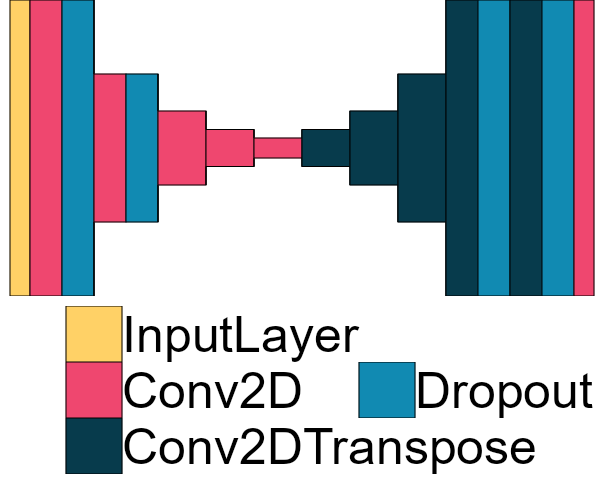

In [ ]:
!pip3 install visualkeras
import visualkeras
from PIL import ImageFont
from collections import defaultdict
from tensorflow.python.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, ZeroPadding2D
font = ImageFont.truetype("arial.ttf", 50)
color_map = defaultdict(dict)
color_map[Conv2D]['fill'] = 'orange'
color_map[ZeroPadding2D]['fill'] = 'gray'
color_map[Dropout]['fill'] = 'pink'
color_map[MaxPooling2D]['fill'] = 'red'
color_map[Dense]['fill'] = 'green'
color_map[Flatten]['fill'] = 'teal'
visualkeras.layered_view(model, legend=True,spacing=0,color_map=color_map, scale_xy=0.5, scale_z=1, max_z=200, font=font, draw_volume=False)

In [ ]:
import pickle

if train_the_model == 1:
    history = model.fit(
      x=train_input_images,
      y=train_output_images,
      epochs=400,
      batch_size=batch_size,
      shuffle=True,
      validation_split=0.1,
      verbose=1,
      callbacks = [early_stopping, lr_scheduler]
    )

    model.save('Trained_JENet_Model_LT.keras')
    with open('Train_History_Dict_LT', 'wb') as file_pi:
        pickle.dump(history, file_pi)

    drive.mount('/content/drive')
    shutil.copy("Train_History_Dict_LT", "/content/drive/MyDrive/3 - JE-Net Data/Train_History_Dict_LT")
    shutil.copy("Trained_JENet_Model_LT.keras", "/content/drive/MyDrive/3 - JE-Net Data/Trained_JENet_Model_LT.keras")
    drive.flush_and_unmount()

else:
    drive.mount('/content/drive')
    shutil.copy("/content/drive/MyDrive/3 - JE-Net Data/Train_History_Dict_LT", "Train_History_Dict_LT")
    shutil.copy("/content/drive/MyDrive/3 - JE-Net Data/Trained_JENet_Model_LT.keras", "Trained_JENet_Model_LT.keras")
    drive.flush_and_unmount()
    model = tf.keras.models.load_model('Trained_JENet_Model_LT.keras', custom_objects={ 'ssim_loss': ssim_loss })
    #with open('Train_History_Dict_LT', "rb") as file_pi:
    #    history = pickle.load(file_pi, custom_objects={ 'ssim_loss': ssim_loss })

Epoch 1/400
1519/1519 [==============================] - 79s 40ms/step - loss: 0.0691 - val_loss: 0.0323 - lr: 0.0010
Epoch 2/400
1519/1519 [==============================] - 52s 34ms/step - loss: 0.0282 - val_loss: 0.0218 - lr: 0.0010
Epoch 3/400
1519/1519 [==============================] - 52s 34ms/step - loss: 0.0206 - val_loss: 0.0173 - lr: 0.0010
Epoch 4/400
1519/1519 [==============================] - 52s 34ms/step - loss: 0.0178 - val_loss: 0.0159 - lr: 0.0010
Epoch 5/400
1519/1519 [==============================] - 52s 34ms/step - loss: 0.0157 - val_loss: 0.0190 - lr: 0.0010
Epoch 6/400
1519/1519 [==============================] - 52s 34ms/step - loss: 0.0148 - val_loss: 0.0122 - lr: 0.0010
Epoch 7/400
1519/1519 [==============================] - 52s 34ms/step - loss: 0.0134 - val_loss: 0.0118 - lr: 0.0010
Epoch 8/400
1519/1519 [==============================] - 51s 34ms/step - loss: 0.0124 - val_loss: 0.0118 - lr: 0.0010
Epoch 9/400
1519/1519 [==============================] -

In [ ]:
if train_the_model == 0:
    drive.mount('/content/drive')
    shutil.copy("/content/drive/MyDrive/3 - JE-Net Data/Train_History_Dict_LT", "Train_History_Dict_LT")
    shutil.copy("/content/drive/MyDrive/3 - JE-Net Data/Trained_JENet_Model_LT.keras", "Trained_JENet_Model_LT.keras")
    drive.flush_and_unmount()
    model = tf.keras.models.load_model('Trained_JENet_Model_LT.keras', custom_objects={ 'ssim_loss': ssim_loss })
    #with open('Train_History_Dict_LT', "rb") as file_pi:
    #    history = pickle.load(file_pi, custom_objects={ 'ssim_loss': ssim_loss })

dict_keys(['loss', 'val_loss', 'lr'])


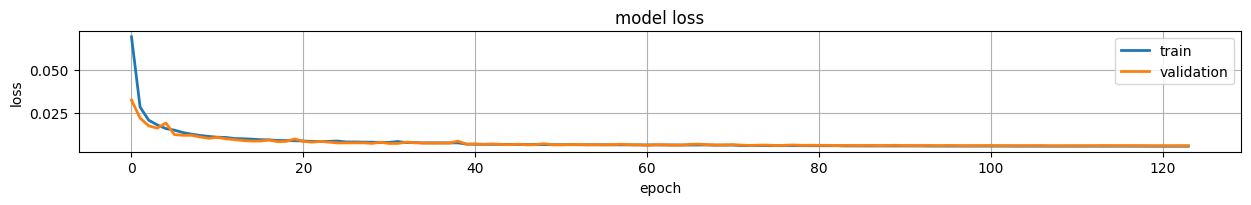

In [ ]:
if train_the_model == 1:
  print(history.history.keys())
  # summarize history for accuracy
  """
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()
  """
  # summarize history for loss
  plt.plot(history.history['loss'],linewidth=2)
  plt.plot(history.history['val_loss'],linewidth=2)
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper right')
  font = {'weight' : 'bold',
          'size'   : 11}
  plt.rc('font', **font)
  plt.grid()

  plt.gca().set_aspect(200)
  plt.show()

  #predictions = autoencoder.predict(test_input_images)
  #display(test_data, predictions)

Test

In [ ]:
predictions = model.predict(test_input_images)
test_prediction_images = tf.convert_to_tensor(predictions)
ssim_loss(test_prediction_images, test_output_images)

47/47 [==============================] - 7s 84ms/step


<tf.Tensor: shape=(), dtype=float32, numpy=0.005124569>

In [ ]:
loss2 = tf.keras.losses.MeanSquaredError()
loss2(test_prediction_images, test_output_images)

<tf.Tensor: shape=(), dtype=float32, numpy=0.0001755791>

In [ ]:
import tensorflow as tf
import numpy as np

# Function to calculate PSNR between two images
def calculate_psnr(image1, image2):
    # Convert images to float32 for precision
    image1 = tf.cast(image1, tf.float32)
    image2 = tf.cast(image2, tf.float32)

    # Calculate MSE (Mean Squared Error)
    mse = tf.reduce_mean(tf.square(image1 - image2))

    # If MSE is zero, it means the images are identical, and PSNR is infinity
    if mse == 0:
        return float('inf')

    # Maximum pixel value (assuming 8-bit images)
    max_pixel_value = 1.0

    # Calculate PSNR
    psnr = 10 * tf.math.log((max_pixel_value ** 2) / mse) / tf.math.log(10.0)
    return psnr

# Assuming you have test_prediction_images and test_output_images as EagerTensors
def calculate_average_psnr(test_prediction_images, test_output_images):
    total_psnr = 0
    num_images = test_prediction_images.shape[0]  # 1500 images

    # Loop over all the images and calculate PSNR
    for i in range(num_images):
        image1 = test_prediction_images[i]
        image2 = test_output_images[i]

        psnr_value = calculate_psnr(image1, image2)
        total_psnr += psnr_value

    # Calculate average PSNR
    average_psnr = total_psnr / num_images
    return average_psnr

# Example usage
average_psnr_value = calculate_average_psnr(test_prediction_images, test_output_images)
print(f'Average PSNR: {average_psnr_value.numpy()} dB')

Average PSNR: 38.86003112792969 dB


(-0.5, 591.5, 239.5, -0.5)

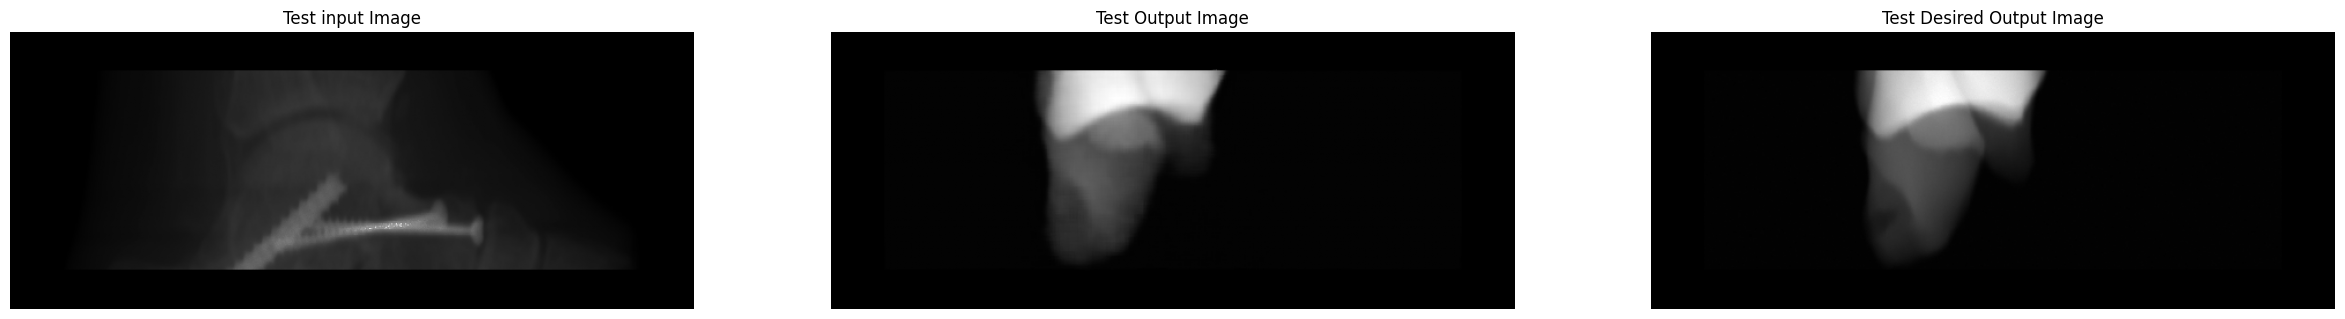

In [ ]:
%matplotlib inline
rand_idx = random.randint(0, len(test_input_images))
im1 = tf.squeeze(tf.slice(test_input_images, begin=[rand_idx,0,0,0], size=[1, image_resolutions[0], image_resolutions[1], 1]),[0,3])
im2 = tf.squeeze(tf.slice(test_prediction_images, begin=[rand_idx,0,0,0], size=[1, image_resolutions[0], image_resolutions[1], 1]),[0,3])
im3 = tf.squeeze(tf.slice(test_output_images, begin=[rand_idx,0,0,0], size=[1, image_resolutions[0], image_resolutions[1], 1]),[0,3])

plt.rcParams['figure.figsize'] = [30, 30]
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 10}
plt.rc('font', **font)
fig, ax = plt.subplots(1,3)
ax[0].imshow(im1, cmap='gray')
ax[1].imshow(im2 , cmap='gray')
ax[2].imshow(im3 , cmap='gray')
ax[0].set_title('Test input Image')
ax[1].set_title('Test Output Image')
ax[2].set_title('Test Desired Output Image')
ax[0].axis('off')
ax[1].axis('off')
ax[2].axis('off')

In [ ]:
from google.colab import runtime
runtime.unassign()